# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

In [8]:
from __future__ import annotations
from typing import Any

from operator import itemgetter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
%store -r

In [9]:
def train_model_and_plot_stats(
    model,
    error,
    learning_rule,
    train_data,
    valid_data,
    num_epochs,
    stats_interval,
    notebook=True,
):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors = {"acc": lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        data_monitors,
        notebook=notebook,
    )

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(
        num_epochs=num_epochs, stats_interval=stats_interval
    )

    # # Plot the change in the validation and training set error over training.
    # fig_1 = plt.figure(figsize=(8, 4))
    # ax_1 = fig_1.add_subplot(111)
    # for k in ['error(train)', 'error(valid)']:
    #     ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
    #               stats[1:, keys[k]], label=k)
    # ax_1.legend(loc=0)
    # ax_1.set_xlabel('Epoch number')

    # # Plot the change in the validation and training set accuracy over training.
    # fig_2 = plt.figure(figsize=(8, 4))
    # ax_2 = fig_2.add_subplot(111)
    # for k in ['acc(train)', 'acc(valid)']:
    #     ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
    #               stats[1:, keys[k]], label=k)
    # ax_2.legend(loc=0)
    # ax_2.set_xlabel('Epoch number')

    # return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2
    return stats, keys, run_time


In [10]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 11102019 
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)

KeysView(<numpy.lib.npyio.NpzFile object at 0x00000152AC33DE70>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x00000152AC33D390>)


In [11]:
def run_model(hidden_dim: int, hidden_layer_count: int) -> Any:
    """
    Run different models specified in the question.
    """
    if hidden_layer_count < 1:
        raise ValueError("There must be at least one hidden layer")

    input_dim, output_dim = 784, 47

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.0)

    layers = [
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
    ]
    for _ in range(hidden_layer_count - 1):
        layers += [
            AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
            ReluLayer(),
        ]
    layers.append(AffineLayer(hidden_dim, output_dim, weights_init, biases_init))
    model = MultipleLayerModel(layers)

    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule()

    # Remember to use notebook=False when you write a script to be run in a terminal
    _ = train_model_and_plot_stats(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        num_epochs,
        stats_interval,
        notebook=True,
    )
    return _


In [12]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

# setup hyperparameters
learning_rate = 0.1
num_epochs = 100
stats_interval = 1
# input_dim, output_dim, hidden_dim = 784, 47, 100

# weights_init = GlorotUniformInit(rng=rng)
# biases_init = ConstantInit(0.)
# model = MultipleLayerModel([
#     AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
#     ReluLayer(),
#     AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
#     ReluLayer(),
#     AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
# ])

# error = CrossEntropySoftmaxError()
# # Use a basic gradient descent learning rule
# learning_rule = AdamLearningRule()

# #Remember to use notebook=False when you write a script to be run in a terminal
# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)


In [13]:
try:
    data_hidden_dim
except NameError:
    data_hidden_dim = {
        32: run_model(32, 1),
        64: run_model(64, 1),
        128: run_model(128, 1),
    }
    %store data_hidden_dim

32: error(train)=5.65e-01, acc(train)=8.20e-01, error(valid)=7.17e-01, acc(valid)=7.85e-01
64: error(train)=3.37e-01, acc(train)=8.82e-01, error(valid)=6.79e-01, acc(valid)=8.06e-01
128: error(train)=1.59e-01, acc(train)=9.39e-01, error(valid)=9.99e-01, acc(valid)=8.02e-01


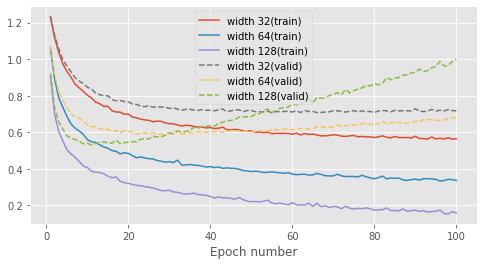

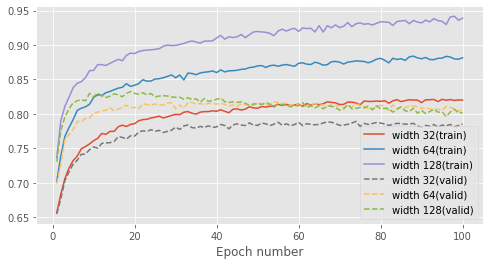

In [20]:
# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)

for i, (k, linestyle) in enumerate({"(train)": "-", "(valid)": "--"}.items()):
    for w, datum in data_hidden_dim.items():
        stats = datum[0]
        keys = datum[1]
        if not i:
            # Only print the first time
            sorted_keys = sorted(keys.items(), key=itemgetter(1))
            stat_str = ", ".join(
                f"{k[0]}={v:.2e}" for (k, v) in zip(sorted_keys, stats[-1])
            )
            print(f"{w}: {stat_str}")
        ax_1.plot(
            np.arange(1, stats.shape[0]) * stats_interval,
            stats[1:, keys[f"error{k}"]],
            label=f"width {w}{k}",
            linestyle=linestyle,
        )
        ax_2.plot(
            np.arange(1, stats.shape[0]) * stats_interval,
            stats[1:, keys[f"acc{k}"]],
            label=f"width {w}{k}",
            linestyle=linestyle,
        )

ax_1.legend(loc=0)
ax_1.set_xlabel("Epoch number")
ax_2.legend(loc=0)
ax_2.set_xlabel("Epoch number")
# Don't print out
None
